[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/diogoflim/MGP/blob/main/modelagem_7.ipynb)

# Modelagem e Gest√£o de Processos


**Prof. Diogo Ferreira de Lima Silva (TEP-UFF)**


C√≥digo produzido a partir de: https://medium.com/mlearning-ai/a-stochastic-model-for-demand-forecating-in-python-a1b568b80b94

# Previs√£o de Demanda - M√©dias M√≥veis

Nessa aula, vamos fazer algumas an√°lises para previs√£o de demanda no Python. Para isso, utilizaremos alguns conjuntos de dados dispon√≠veis no Kaggle.
 

### Importando Bibliotecas

Importaremos as seguintes bibliotecas:

- pandas: biblioteca muito utilizada para an√°lise de dados em formato tabular (assim como um Excel).
- matplotlib.pyplot: pacote vastamente utilizado para visualiza√ß√µes.


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline  

### Importa√ß√£o e limpeza dos dados

Inicialmente, vamos importar os dados.

In [6]:
# Como os nossos dados possuem uma coluna de datas, avisaremos isso ao python. 

url = 'https://raw.githubusercontent.com/diogoflim/MGP/main/dados/dados_passageiros.csv'


dados_brutos = pd.read_csv(url, index_col=0, parse_dates=["Month"])
dados_brutos

#Passengers
Month                  
1949-01-01          112
1949-02-01          118
1949-03-01          132
1949-04-01          129
1949-05-01          121
...                 ...
1960-08-01          606
1960-09-01          508
1960-10-01          461
1960-11-01          390
1960-12-01          432

[144 rows x 1 columns]

Nossos dados parecem estar organizados. Vou apenas renomear as colunas. 

Antes disso, criarei uma c√≥pia para deixarmos guardados os dados brutos 

In [7]:
dados_modificados = dados_brutos.rename(columns={"#Passengers": "Passageiros"}).rename_axis("M√™s") # Muda o nome das colunas
dados = dados_modificados.copy()

### Visualiza√ß√£o inicial

Inicialmente, podemos perceber que nossos temos 144 observa√ß√µes de demandas mensais de passageiros, entre 1949 e 1960.

Uma visualiza√ß√£o b√°sica pode nos ajudar a entender o funcionamento da demanda.

Vamos usar um simples gr√°fico de linha.

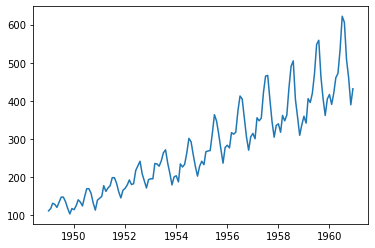

In [8]:
plt.plot(dados)
plt.show()

A demanda cresceu ao longo dos anos. Por√©m, um comportamento c√≠clico parece ter sido detectado.

O que poderia ser?

- **Talvez alguns meses (exemplo: f√©rias) impactem a demanda por passageiros.**  

In [9]:
dados.groupby(by=[dados.index.month]).mean()

Passageiros
M√™s             
1     241.750000
2     235.000000
3     270.166667
4     267.083333
5     271.833333
6     311.666667
7     351.333333
8     351.083333
9     302.416667
10    266.583333
11    232.833333
12    261.833333

A an√°lise indica uma maior m√©dia nos meses de **ver√£o no hemisf√©rio norte!**

Vamos seguir para os modelos de s√©ries temporais.

### M√©dia m√≥vel simples (SMA)


Vamos aplicar uma m√©dia m√≥vel simples com tempo igual a 3

In [11]:
k=3
dados.rolling(k).mean().shift(1)

Passageiros
M√™s                    
1949-01-01          NaN
1949-02-01          NaN
1949-03-01          NaN
1949-04-01   120.666667
1949-05-01   126.333333
...                 ...
1960-08-01   543.000000
1960-09-01   587.666667
1960-10-01   578.666667
1960-11-01   525.000000
1960-12-01   453.000000

[144 rows x 1 columns]

In [12]:
# Criaremos uma nova coluna que receber√° essa an√°lise!
dados["MM_3"]= dados["Passageiros"].rolling(k).mean().shift(1)
dados

Passageiros        MM_3
M√™s                                
1949-01-01          112         NaN
1949-02-01          118         NaN
1949-03-01          132         NaN
1949-04-01          129  120.666667
1949-05-01          121  126.333333
...                 ...         ...
1960-08-01          606  543.000000
1960-09-01          508  587.666667
1960-10-01          461  578.666667
1960-11-01          390  525.000000
1960-12-01          432  453.000000

[144 rows x 2 columns]

Seguindo esse racioc√≠nio, poder√≠amos fazer v√°rias ao mesmo tempo

In [13]:
dados_sma = dados_modificados.copy()

for k in [3, 6, 9, 12]: 
    dados_sma ["MM_" + str(k)] = dados_sma["Passageiros"].rolling(k).mean().shift(1)

dados_sma

Passageiros        MM_3        MM_6        MM_9       MM_12
M√™s                                                                    
1949-01-01          112         NaN         NaN         NaN         NaN
1949-02-01          118         NaN         NaN         NaN         NaN
1949-03-01          132         NaN         NaN         NaN         NaN
1949-04-01          129  120.666667         NaN         NaN         NaN
1949-05-01          121  126.333333         NaN         NaN         NaN
...                 ...         ...         ...         ...         ...
1960-08-01          606  543.000000  483.333333  453.777778  459.416667
1960-09-01          508  587.666667  519.166667  480.888889  463.333333
1960-10-01          461  578.666667  534.000000  492.333333  467.083333
1960-11-01          390  525.000000  534.000000  497.222222  471.583333
1960-12-01          432  453.000000  520.333333  497.111111  473.916667

[144 rows x 5 columns]

<AxesSubplot:xlabel='M√™s'>

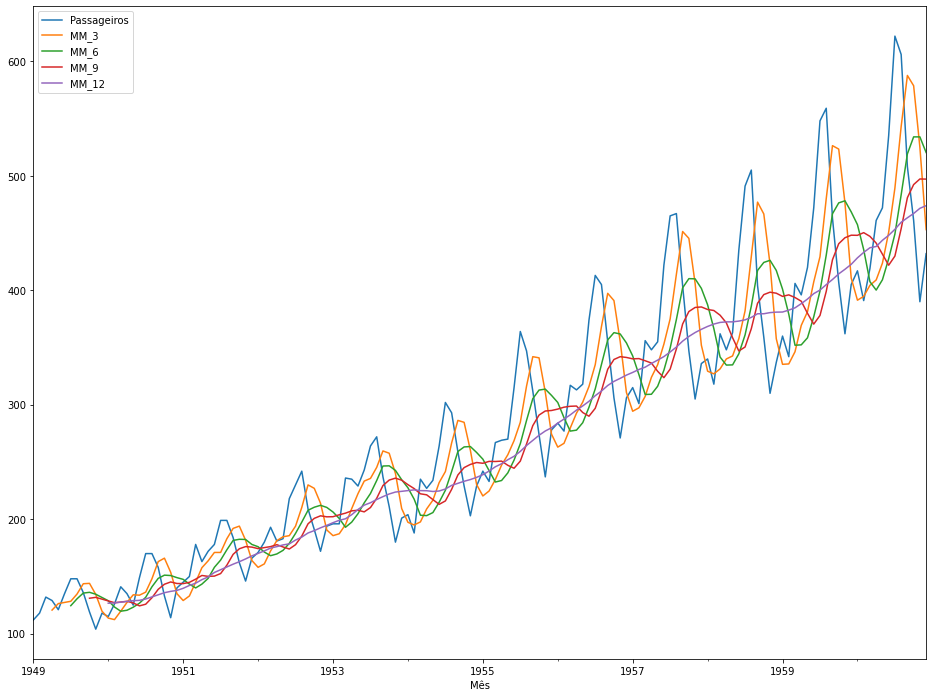

In [14]:
dados_sma.plot(figsize=(16,12))

Perceba que valores mais altos de $k$ de alguma maneira suavizam a m√©dia! Estamos perdendo o efeito sazonal.

Vamos analisar o modelo de suaviza√ß√£o exponencial.


### M√©dia M√≥vel Exponencialmente Ponderada (EWMA)

In [15]:
dados_ewma = dados_modificados.copy()

In [16]:
dados_ewma["alfa=0,5"] = dados_ewma["Passageiros"].ewm(alpha=0.5, adjust=False).mean()
dados_ewma

Passageiros    alfa=0,5
M√™s                                
1949-01-01          112  112.000000
1949-02-01          118  115.000000
1949-03-01          132  123.500000
1949-04-01          129  126.250000
1949-05-01          121  123.625000
...                 ...         ...
1960-08-01          606  582.096411
1960-09-01          508  545.048205
1960-10-01          461  503.024103
1960-11-01          390  446.512051
1960-12-01          432  439.256026

[144 rows x 2 columns]

### Considerando a Sazonalidade

Para considerar a sazonalidade, usaremos o procedimento visto na aula:

O efeito sazonal √© dado por: $$\frac{\text{ùëö√©ùëëùëñùëé ùëëùëú ùëö√™ùë†}}{\text{ùëö√©ùëëùëñùëé ùë°ùëúùë°ùëéùëô}}$$

Uma vez calculado, faremos os passos:

1. Use a f√≥rmula a seguir para ajustar os dados com o efeito sazonal: $ ùëâùëéùëôùëúùëü ùëéùëóùë¢ùë†ùë°ùëéùëëùëú = \frac{\text{ùëâùëéùëôùëúùëü ùëúùëèùë†ùëíùëüùë£ùëéùëëùëú}}{\text{ùê∏ùëìùëíùëñùë°ùëú ùëÜùëéùëßùëúùëõùëéùëô}}$

2. Escolha um m√©todo de previs√£o

3. Aplique o m√©todo de previs√£o aos dados ajustados (que consideram o efeito sazonal)

4. Multiplique essa previs√£o pelo efeito sazonal correspondente para obter o valor de previs√£o real (sem o ajuste sazonal)


In [17]:
dados_ajustados = dados_modificados.copy()
dados_ajustados

Passageiros
M√™s                    
1949-01-01          112
1949-02-01          118
1949-03-01          132
1949-04-01          129
1949-05-01          121
...                 ...
1960-08-01          606
1960-09-01          508
1960-10-01          461
1960-11-01          390
1960-12-01          432

[144 rows x 1 columns]

Inicialmente, precisamos calcular o efeito sazonal. Para isso, usamos a m√©dia mensal e a m√©dia total.

In [18]:
# M√©dia total
dados_ajustados.mean()

Passageiros    280.298611
dtype: float64

In [19]:
# M√©dia por m√™s

dados_ajustados.groupby(by=[dados_ajustados.index.month]).mean()

Passageiros
M√™s             
1     241.750000
2     235.000000
3     270.166667
4     267.083333
5     271.833333
6     311.666667
7     351.333333
8     351.083333
9     302.416667
10    266.583333
11    232.833333
12    261.833333

In [20]:
efeito_sazonal = dados_ajustados.groupby(by=[dados_ajustados.index.month]).mean() / dados_ajustados.mean()
efeito_sazonal

Passageiros
M√™s             
1       0.862473
2       0.838392
3       0.963853
4       0.952853
5       0.969799
6       1.111909
7       1.253425
8       1.252533
9       1.078909
10      0.951069
11      0.830662
12      0.934123

De posse dessa informa√ß√£o, vamos para o passo 1 do procedimento. Devemos dividir cada valor pelo seu efeito sazonal correspondente.

In [21]:
efeito_sazonal.loc[10]

Passageiros    0.951069
Name: 10, dtype: float64

In [22]:
dados_ajustados["x_t ajustado"] = dados_ajustados["Passageiros"]

for i in range (len(dados_ajustados)):
    mes = dados_ajustados.iloc[i].name.month
    dados_ajustados["x_t ajustado"].iloc[i] = dados_ajustados["x_t ajustado"].iloc[i] / efeito_sazonal.loc[mes] 



c:\Anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [23]:
dados_ajustados

Passageiros  x_t ajustado
M√™s                                  
1949-01-01          112    129.859129
1949-02-01          118    140.745686
1949-03-01          132    136.950339
1949-04-01          129    135.382917
1949-05-01          121    124.768113
...                 ...           ...
1960-08-01          606    483.819487
1960-09-01          508    470.846055
1960-10-01          461    484.717698
1960-11-01          390    469.505190
1960-12-01          432    462.465945

[144 rows x 2 columns]

Agora, podemos aplicar uma previs√£o usando o x_t ajustado.

Vamos utilizar a suaviza√ß√£o exponencial.

In [24]:
dados_ajustados["ewma_ajustado"]= dados_ajustados["x_t ajustado"].ewm(alpha=0.5, adjust=False).mean()

for k in [3, 6, 9, 12]: 
    dados_ajustados ["MM_" + str(k) + "_ajustado"] = dados_ajustados["Passageiros"].rolling(k).mean().shift(1)

dados_ajustados

Passageiros  x_t ajustado  ewma_ajustado  MM_3_ajustado  \
M√™s                                                                   
1949-01-01          112    129.859129     129.859129            NaN   
1949-02-01          118    140.745686     135.302407            NaN   
1949-03-01          132    136.950339     136.126373            NaN   
1949-04-01          129    135.382917     135.754645     120.666667   
1949-05-01          121    124.768113     130.261379     126.333333   
...                 ...           ...            ...            ...   
1960-08-01          606    483.819487     485.669529     543.000000   
1960-09-01          508    470.846055     478.257792     587.666667   
1960-10-01          461    484.717698     481.487745     578.666667   
1960-11-01          390    469.505190     475.496467     525.000000   
1960-12-01          432    462.465945     468.981206     453.000000   

            MM_6_ajustado  MM_9_ajustado  MM_12_ajustado  
M√™s                                                       
1949-01-01            NaN            NaN             NaN  
1949-02-01            NaN            NaN             NaN  
1949-03-01            NaN            NaN             NaN  
1949-04-01            NaN            NaN             NaN  
1949-05-01            NaN            NaN             NaN  
...                   ...            ...             ...  
1960-08-01     483.333333     453.777778      459.416667  
1960-09-01     519.166667     480.888889      463.333333  
1960-10-01     534.000000     492.333333      467.083333  
1960-11-01     534.000000     497.222222      471.583333  
1960-12-01     520.333333     497.111111      473.916667  

[144 rows x 7 columns]

In [25]:
dados_ajustados["ewma"] = dados_ajustados["ewma_ajustado"]
for k in [3, 6, 9, 12]:  dados_ajustados ["MM_" + str(k)] = dados_ajustados ["MM_" + str(k) + "_ajustado"]


for i in range (len(dados_ajustados)):
    mes = dados_ajustados.iloc[i].name.month
    dados_ajustados["ewma"].iloc[i] = dados_ajustados["ewma"].iloc[i] * efeito_sazonal.loc[mes]
    for k in [3, 6, 9, 12]:
        dados_ajustados ["MM_" + str(k)].iloc[i] = dados_ajustados ["MM_" + str(k)].iloc[i] * efeito_sazonal.loc[mes]

c:\Anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [26]:
dados_ajustados

Passageiros  x_t ajustado  ewma_ajustado  MM_3_ajustado  \
M√™s                                                                   
1949-01-01          112    129.859129     129.859129            NaN   
1949-02-01          118    140.745686     135.302407            NaN   
1949-03-01          132    136.950339     136.126373            NaN   
1949-04-01          129    135.382917     135.754645     120.666667   
1949-05-01          121    124.768113     130.261379     126.333333   
...                 ...           ...            ...            ...   
1960-08-01          606    483.819487     485.669529     543.000000   
1960-09-01          508    470.846055     478.257792     587.666667   
1960-10-01          461    484.717698     481.487745     578.666667   
1960-11-01          390    469.505190     475.496467     525.000000   
1960-12-01          432    462.465945     468.981206     453.000000   

            MM_6_ajustado  MM_9_ajustado  MM_12_ajustado        ewma  \
M√™s                                                                    
1949-01-01            NaN            NaN             NaN  112.000000   
1949-02-01            NaN            NaN             NaN  113.436401   
1949-03-01            NaN            NaN             NaN  131.205818   
1949-04-01            NaN            NaN             NaN  129.354202   
1949-05-01            NaN            NaN             NaN  126.327365   
...                   ...            ...             ...         ...   
1960-08-01     483.333333     453.777778      459.416667  608.317238   
1960-09-01     519.166667     480.888889      463.333333  515.996589   
1960-10-01     534.000000     492.333333      467.083333  457.928091   
1960-11-01     534.000000     497.222222      471.583333  394.976725   
1960-12-01     520.333333     497.111111      473.916667  438.086054   

                  MM_3        MM_6        MM_9       MM_12  
M√™s                                                         
1949-01-01         NaN         NaN         NaN         NaN  
1949-02-01         NaN         NaN         NaN         NaN  
1949-03-01         NaN         NaN         NaN         NaN  
1949-04-01  114.977578         NaN         NaN         NaN  
1949-05-01  122.517950         NaN         NaN         NaN  
...                ...         ...         ...         ...  
1960-08-01  680.125561  605.391076  568.371760  575.434656  
1960-09-01  634.038798  560.133538  518.835303  499.894458  
1960-10-01  550.351956  507.870872  468.242995  444.228501  
1960-11-01  436.097416  443.573372  413.023479  391.726234  
1960-12-01  423.157644  486.055249  464.362841  442.696380  

[144 rows x 12 columns]

In [27]:
from sklearn.metrics import mean_squared_error

In [28]:
print("Erro M√©dio Quadr√°tico sem considerar a sazonalidade:")
print(f'Suaviza√ß√£o Exponencial com alfa = 0,5: {mean_squared_error(dados_ewma["Passageiros"].iloc[-30:], dados_ewma["alfa=0,5"].iloc[-30:])}')
print(f'M√©dia m√≥vel com k = 3: {mean_squared_error(dados_sma["Passageiros"].iloc[-30:], dados_sma["MM_3"].iloc[-30:])}')
print(f'M√©dia m√≥vel com k = 6: {mean_squared_error(dados_sma["Passageiros"].iloc[-30:], dados_sma["MM_6"].iloc[-30:])}')
print(f'M√©dia m√≥vel com k = 9: {mean_squared_error(dados_sma["Passageiros"].iloc[-30:], dados_sma["MM_9"].iloc[-30:])}')
print(f'M√©dia m√≥vel com k = 12: {mean_squared_error(dados_sma["Passageiros"].iloc[-30:], dados_sma["MM_12"].iloc[-30:])}')




print("-------------------------------------------")

print("Erro M√©dio Quadr√°tico considerando a sazonalidade:")
print(f'Suaviza√ß√£o Exponencial com alfa = 0,5: {mean_squared_error(dados_ajustados["Passageiros"].iloc[-30:], dados_ajustados["ewma"].iloc[-30:])}')
print(f'M√©dia m√≥vel com k = 3: {mean_squared_error(dados_ajustados["Passageiros"].iloc[-30:], dados_ajustados["MM_3"].iloc[-30:])}')
print(f'M√©dia m√≥vel com k = 6: {mean_squared_error(dados_ajustados["Passageiros"].iloc[-30:], dados_ajustados["MM_6"].iloc[-30:])}')
print(f'M√©dia m√≥vel com k = 9: {mean_squared_error(dados_ajustados["Passageiros"].iloc[-30:], dados_ajustados["MM_9"].iloc[-30:])}')
print(f'M√©dia m√≥vel com k = 12: {mean_squared_error(dados_ajustados["Passageiros"].iloc[-30:], dados_ajustados["MM_12"].iloc[-30:])}')


Erro M√©dio Quadr√°tico sem considerar a sazonalidade:
Suaviza√ß√£o Exponencial com alfa = 0,5: 1117.7321124867788
M√©dia m√≥vel com k = 3: 6087.7851851851865
M√©dia m√≥vel com k = 6: 7963.832407407407
M√©dia m√≥vel com k = 9: 7724.23086419753
M√©dia m√≥vel com k = 12: 5688.169212962963
-------------------------------------------
Erro M√©dio Quadr√°tico considerando a sazonalidade:
Suaviza√ß√£o Exponencial com alfa = 0,5: 84.18770649715597
M√©dia m√≥vel com k = 3: 3873.250252458434
M√©dia m√≥vel com k = 6: 2267.7389673048847
M√©dia m√≥vel com k = 9: 1486.9747599586851
M√©dia m√≥vel com k = 12: 866.3795301543986
